In [1]:
parameter_file = '../parameters/STAR_get_bam.yaml'

import yaml
import sys
import glob
import os
import seaborn as sns
from os.path import join, basename
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
with open(parameter_file,'r') as f:
    doc = yaml.load(f)

print(doc)

samples = pd.read_csv('../parameters/samples.tsv',sep='\t')

sys.path.append(doc["NGS_folder"])
sys.path.append(os.path.join(doc["NGS_folder"],'Modules'))
from f01_file_process import *
p = dic2obj(**doc)
p


from collections import defaultdict

from mplh.fig_utils import helper_save, legend_from_color
from mplh.color_utils import get_colors


{'contact': 'ishamie14@gmail.com', 'RawDataPath': '/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/', 'NGS_folder': '/home/isshamie/software/NGS-Pipeline', 'thread': 8, 'ref_fa': '/data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna', 'gff': '/data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3', 'annotation': '/data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3', 'gtf': '/data/isshamie/genome/ncbi_anno_103/alt_CriGri-PICR_top_level.gtf', 'QC': False, 'trim_reads': False, 'trimmomatic_path': '/home/shangzhong/Installation/Trimmomatic-0.32/Trimmomatic-0.33/trimmomatic-0.33.jar', 'trim_jobs_per_batch': 6, 'adapter': '', 'picard': '/home/shangzhong/Installation/picard-tools-1.141/picard.jar', 'star_jobs_per_batch': 2, 'star_index_path': '/data/isshamie/genome/ncbi_anno_103/CriGri-PICR_STAR_db', 'STAR_index_path': '/data/isshamie/genome/ncbi_anno_103/CriGri-PICR_STAR_db', 'star_pass': 2, 'star_params': [], 'htseq_anno_source': 'ncbi', '

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  del sys.path[0]


In [4]:
file_path = p.RawDataPath
thread = p.thread
QC = p.QC
# all parameter
ref_fa = p.ref_fa
annotation = p.gff
gtf_anno = p.gtf
# trimmomatic parameter
trim = p.trim_reads
trimmomatic = p.trimmomatic_path
trim_batch = p.trim_jobs_per_batch
adapter = p.adapter
# star parameter
star_batch = p.star_jobs_per_batch
db_path = p.STAR_index_path
# htseq parameter
htseq_anno_source = p.htseq_anno_source
strand = p.strand_specific
id_name = p.id_name

contact = p.contact

In [5]:
qc_dir = join(file_path,"QC")
multiqc_dir = join(file_path,"multiqc")

trim_qc_dir = join(file_path,"trim_QC")
trim_multiqc_dir = join(file_path,"trim_multiqc")

bam_dir = join(file_path, "sortBam")
ht_dir = join(file_path, 'htseq')
ht_reverse_dir = join(file_path, 'htseq_rev')
RNA_SeQC = join(file_path,'RNA_SeQC')

In [6]:
all_df = pd.DataFrame()


for bam_f in glob.glob(ht_reverse_dir+"/*.count.txt"):
    print(bam_f)
    sid = basename(bam_f).replace('.count.txt','') #"_".join(basename(bam_f).split("_")[1:3])
    print(sid)
    #NL9_Kidney_S9_L006_R1_001.fastq.sort
    count_rev_f = join(ht_reverse_dir, sid +'.count.txt')

    df_rev = pd.read_csv(count_rev_f,sep="\t", header=None, index_col=0)
    df_rev = df_rev[~(df_rev.index.str.contains("_"))]
    df_rev.columns = [sid]

    all_df = pd.concat((all_df,df_rev), axis=1)



/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Muscle_S8.count.txt
Muscle_S8
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Brain2_S7.count.txt
Brain2_S7
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Lung_S4.count.txt
Lung_S4
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Heart_S6.count.txt
Heart_S6
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Misc_S10.count.txt
Misc_S10
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Brain7-1_S11.count.txt
Brain7-1_S11
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Liver_S5.count.txt
Liver_S5
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/ReproductiveTract_S2.count.txt
ReproductiveTract_S2
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Kidney_S9.count.txt
Kidney_S9
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Spleen_S3.count.txt
Spleen_S3
/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/Pancreas_S1.count.txt


## Get mean and var for tissues 

In [7]:
rna_samples = samples[samples['Experiment']=='RNASeq']
rna_samples

,Unnamed: 0,Experiment,Full,Name,Tissue
67,NL10_Misc_S10_L006_R1_001.fastq.gz,RNASeq,NL10_Misc_S10_L006_R1_001.fastq.gz,Misc_RNASeq1,MiscOrgans
68,NL11_Brain7-1_S11_L006_R1_001.fastq.gz,RNASeq,NL11_Brain7-1_S11_L006_R1_001.fastq.gz,Brain_RNASeq1,Brain
69,NL1_Pancreas_S1_L006_R1_001.fastq.gz,RNASeq,NL1_Pancreas_S1_L006_R1_001.fastq.gz,Pancreas_RNASeq1,Pancreas
70,NL2_ReproductiveTract_S2_L006_R1_001.fastq.gz,RNASeq,NL2_ReproductiveTract_S2_L006_R1_001.fastq.gz,ReproductiveTract_RNASeq1,FemaleReproductive
71,NL3_Spleen_S3_L006_R1_001.fastq.gz,RNASeq,NL3_Spleen_S3_L006_R1_001.fastq.gz,Spleen_RNASeq1,Spleen
72,NL4_Lung_S4_L006_R1_001.fastq.gz,RNASeq,NL4_Lung_S4_L006_R1_001.fastq.gz,Lung_RNASeq1,Lung
73,NL5_Liver_S5_L006_R1_001.fastq.gz,RNASeq,NL5_Liver_S5_L006_R1_001.fastq.gz,Liver_RNASeq1,Liver
74,NL6_Heart_S6_L006_R1_001.fastq.gz,RNASeq,NL6_Heart_S6_L006_R1_001.fastq.gz,Heart_RNASeq1,Heart
75,NL7_Brain2_S7_L006_R1_001.fastq.gz,RNASeq,NL7_Brain2_S7_L006_R1_001.fastq.gz,Brain_RNASeq2,Brain
76,NL8_Muscle_S8_L006_R1_001.fastq.gz,RNASeq,NL8_Muscle_S8_L006_R1_001.fastq.gz,Muscle_RNASeq1,Muscle


In [8]:
# tpm <- function(counts, lengths) {
#   rate <- counts / lengths
#   rate / sum(rate) * 1e6
# }

In [9]:
color_map, name_map, p = get_colors(scheme='categorical', names=rna_samples["Tissue"].values, n_colors=len(rna_samples["Tissue"].unique()), use_white=False)


Generating palette: 100% |######################################| Time: 0:00:08


In [10]:
tis_map = dict()
for name in all_df.columns.values:
    print(name)
    for _, val in rna_samples.iterrows():
        if name in val['Full']:
            if name in tis_map:
                print('Already here', name)
            else:
                tis_map[name] = val["Tissue"]
tis_rev = defaultdict(list)
for t in tis_map:
    tis_rev[tis_map[t]].append(t)
print(tis_rev)
tis_map

Muscle_S8
Brain2_S7
Lung_S4
Heart_S6
Misc_S10
Brain7-1_S11
Liver_S5
ReproductiveTract_S2
Kidney_S9
Spleen_S3
Pancreas_S1
defaultdict(<class 'list'>, {'Muscle': ['Muscle_S8'], 'Brain': ['Brain2_S7', 'Brain7-1_S11'], 'Lung': ['Lung_S4'], 'Heart': ['Heart_S6'], 'MiscOrgans': ['Misc_S10'], 'Liver': ['Liver_S5'], 'FemaleReproductive': ['ReproductiveTract_S2'], 'Kidney': ['Kidney_S9'], 'Spleen': ['Spleen_S3'], 'Pancreas': ['Pancreas_S1']})


{'Muscle_S8': 'Muscle',
 'Brain2_S7': 'Brain',
 'Lung_S4': 'Lung',
 'Heart_S6': 'Heart',
 'Misc_S10': 'MiscOrgans',
 'Brain7-1_S11': 'Brain',
 'Liver_S5': 'Liver',
 'ReproductiveTract_S2': 'FemaleReproductive',
 'Kidney_S9': 'Kidney',
 'Spleen_S3': 'Spleen',
 'Pancreas_S1': 'Pancreas'}

## A. Get mean for each gene over tissues (average the brain)
## B. For each tissue : rank order the genes for that tissue
## C. calculate to cumulative sum.
## D. plot the cumulative plot with variance 

MiscOrgans
Brain
Pancreas
FemaleReproductive
Spleen
Lung
Liver
Heart
Muscle
Kidney


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


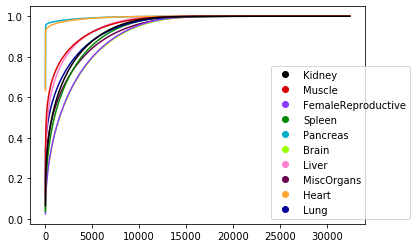

In [11]:
tis_cum_plot_mean = {}
tis_cum_plot_var = {}
f, ax = plt.subplots()
for tis in rna_samples["Tissue"].unique():
    print(tis)
    curr_df = all_df.loc[:, tis_rev[tis]]
    tis_cum_plot_mean[tis] = curr_df.mean(axis=1)
    tis_cum_plot_var[tis] = curr_df.var(axis=1)
    curr_cum = (tis_cum_plot_mean[tis].sort_values(ascending=False).cumsum()/(tis_cum_plot_mean[tis].sum()))
    sns.lineplot(data = curr_cum.reset_index(drop=True), ax=ax, color=color_map[tis])
legend_from_color(color_map, curr_ax=ax)

## Log values

Text(0.5, 1.0, 'Log 2')

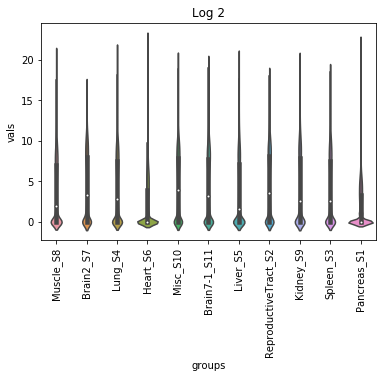

In [20]:
all_df_log = np.log2(all_df+1)
#df.melt(var_name='groups', value_name='vals')
sns.violinplot(x="groups", y="vals", data=all_df_log.melt(var_name='groups', value_name='vals'))
plt.xticks(rotation=90)
plt.title("Log 2")

Text(0.5, 1.0, 'Log 10')

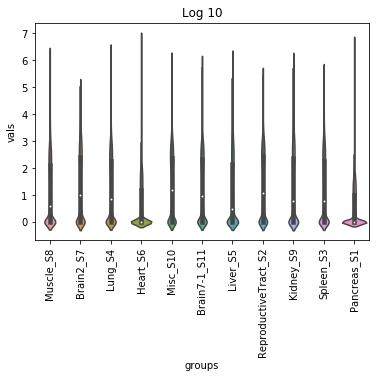

In [21]:
all_df_log = np.log10(all_df+1)
#df.melt(var_name='groups', value_name='vals')
sns.violinplot(x="groups", y="vals", data=all_df_log.melt(var_name='groups', value_name='vals'))
plt.xticks(rotation=90)
plt.title("Log 10")

MiscOrgans
Brain
Pancreas
FemaleReproductive
Spleen
Lung
Liver
Heart
Muscle
Kidney


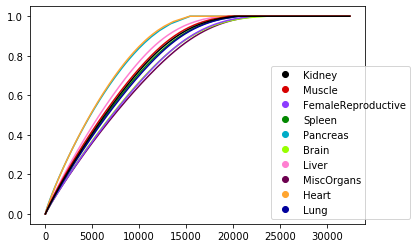

In [22]:
tis_cum_plot_mean = {}
tis_cum_plot_var = {}
f, ax = plt.subplots()
for tis in rna_samples["Tissue"].unique():
    print(tis)
    curr_df = all_df_log.loc[:, tis_rev[tis]]
    tis_cum_plot_mean[tis] = curr_df.mean(axis=1)
    tis_cum_plot_var[tis] = curr_df.var(axis=1)
    curr_cum = (tis_cum_plot_mean[tis].sort_values(ascending=False).cumsum()/(tis_cum_plot_mean[tis].sum()))
    sns.lineplot(data = curr_cum.reset_index(drop=True), ax=ax, color=color_map[tis])
legend_from_color(color_map, curr_ax=ax)